In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jul  3 11:47:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle


from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [31]:
df_train = pd.read_csv('/content/drive/MyDrive/Sign_dataset/sign_mnist_train/sign_mnist_train.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [34]:
#nl = 150
nl = 300

def load_training_data(path):
  df = pd.read_csv(path)

  for i in range(0,25):
    if (i == 9 or i == 25):
      continue
    else:
      temp = df.loc[df['label'] == i]
      #print(temp)

      temp_sub = temp.drop('label', axis=1).to_numpy()

      # x = np.array([temp_sub.iloc[k].to_numpy().reshape((28, 28))
      #   for k in range(len(temp_sub))]).astype(float)
      # x = np.expand_dims(x, axis=3)

      if (i == 0):
        XL = temp_sub[range(0,nl),:]
        YL = i*np.ones(nl)
      else:
        if(i < 9):
          XL = np.concatenate((XL,temp_sub[range(0,nl),:]),axis=0)
          YL = np.append(YL,i*np.ones(nl))
        else:
          XL = np.concatenate((XL,temp_sub[range(0,nl),:]),axis=0)
          YL = np.append(YL,(i-1)*np.ones(nl)) #### <---- ho messo -1 qua, cosi crea labels che vanno da 0 a 23 senza buchi intermedi
  #YL = pd.get_dummies(YL).values

  return XL, YL

X_train, Y_train = load_training_data('/content/drive/MyDrive/Sign_dataset/sign_mnist_train/sign_mnist_train.csv')

print(X_train.shape)
print(Y_train.shape)

(7200, 784)
(7200,)


In [41]:
# Randomizzare le righe del dataset ordinato (il risultato finale non cambia)
TRAIN = np.c_[X_train, Y_train] # aggiunge la colonna Y_train alla matrice X_train alla fine

TRAIN1 = shuffle(TRAIN, random_state=0) # random operation

X_train = TRAIN1[:, 0:784] # estrapolare la matrice X_train
Y_train = TRAIN1[:, 784] # estrapolare la colonna Y_train delle label

In [43]:
# nt = 38
nt = 76

def load_testing_data(path):
  df = pd.read_csv(path)

  for i in range(0,25):
    if (i == 9 or i == 25):
      continue
    else:

      temp = df.loc[df['label'] == i]
      #print(temp)

      temp_sub = temp.drop('label', axis=1).to_numpy()

      # x = np.array([temp_sub.iloc[k].to_numpy().reshape((28, 28))
      #   for k in range(len(temp_sub))]).astype(float)
      # x = np.expand_dims(x, axis=3)

      if (i == 0):
        X = temp_sub[range(0,nt),:]
        Y = i*np.ones(nt)
      else:
        if(i < 9):
          X = np.concatenate((X,temp_sub[range(0,nt),:]),axis=0)
          Y = np.append(Y,i*np.ones(nt))
        else:
          X = np.concatenate((X,temp_sub[range(0,nt),:]),axis=0)
          Y = np.append(Y,(i-1)*np.ones(nt)) #### <---- ho messo -1 qua, cosi crea labels che vanno da 0 a 23 senza buchi intermedi

  #Y = pd.get_dummies(Y).values

  return X, Y

X_test, Y_test = load_testing_data('/content/drive/MyDrive/Sign_dataset/sign_mnist_test/sign_mnist_test.csv')

print(X_test.shape)
print(Y_test.shape)


(1824, 784)
(1824,)


In [40]:
print(Y_test) # prova fatta con nt = 2 ...viene giusto sembrerebbe

[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5.  6.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14. 15. 15. 16. 16. 17. 17.
 18. 18. 19. 19. 20. 20. 21. 21. 22. 22. 23. 23.]


In [ ]:
print(X_train[0])

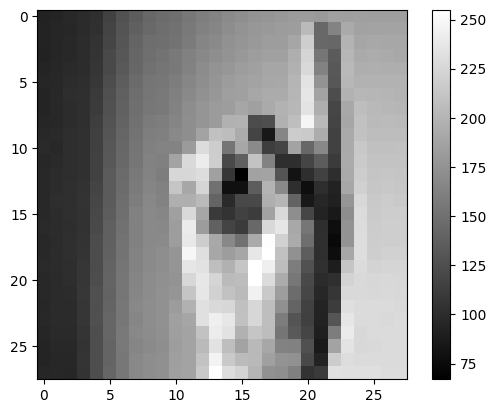

In [45]:
i = 0
fig = plt.figure()

tmp = np.reshape(X_train[i,:], (28,28))
plt.imshow(tmp, cmap = 'gray')
plt.colorbar()

In [46]:
scalerX = preprocessing.MinMaxScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [47]:
class_names = list(string.ascii_lowercase[:26].replace('j', '').replace('z', ''))
print("class: ", class_names)

class:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [105]:
# class_names = list(string.ascii_lowercase[:26])
# print("class: ", class_names)

class:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# print(class_names[int(Y_train[8])])
for i in range(len(Y_train)):
  if Y_train[i] == 9.0:
    print(i)
    print('trovato ')
# print(Y_train[3900])

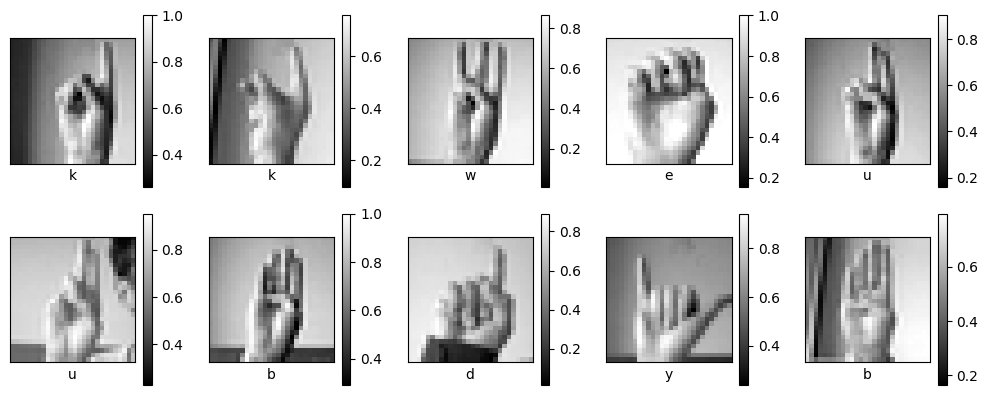

In [49]:
plt.figure(figsize=(10, 10))
a = 0
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  tmp = np.reshape(X_train[i+a,:], (28,28))
  plt.imshow(tmp, cmap = 'gray')
  plt.colorbar()
  # plt.imshow(X_train[i].squeeze(), cmap=plt.cm.binary)
  # if (class_names[int(Y_train)] == 'j' or class_names[int(Y_train)] == 25):
  #     continue
  # else:
  plt.xlabel(class_names[int((Y_train)[i+a])])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

grid = {'C': np.logspace(-4,3,5), # start point (10^), end point (10^), number of points, scala logaritimica
        'kernel': ['linear']}     # test anche con gaussiano, timing consuming

MS = GridSearchCV(estimator = SVC(), #
                  param_grid = grid,
                  scoring = 'accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 1)

H = MS.fit(X_train,Y_train)

print('Logspace points C: ', H.best_params_['C'])
print('Kernel: ', H.best_params_['kernel'])

M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



Fitting 10 folds for each of 5 candidates, totalling 50 fits
Logspace points C:  17.78279410038923
Kernel:  linear
[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0 33  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  4 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 32  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  6 16  0  0  0  0  0  0  9  0  0  5  0  1  0  0]
 [ 0  0  3  0  0  0  0  0  0  0 23  0  0  0  2  0  0  0  0  0  0  0 10  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 25  6  0  0  0  0  5  0  

<Figure size 640x480 with 0 Axes>

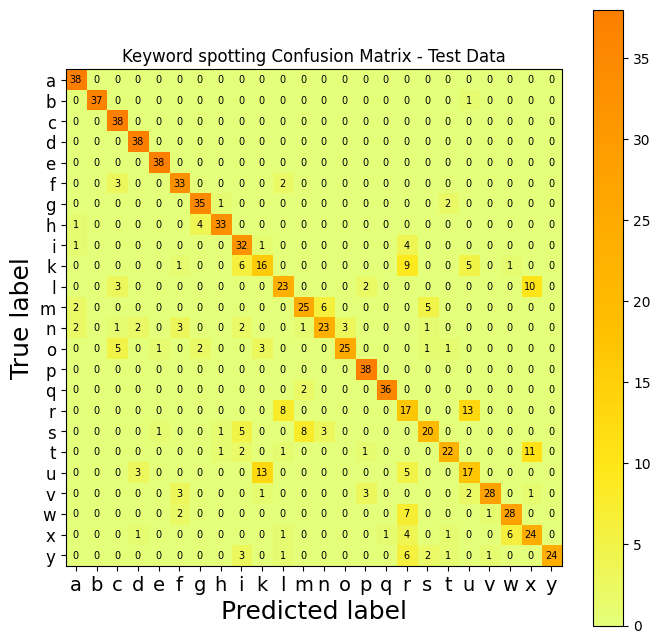

The accuracy is:  0.7543859649122807


In [ ]:
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Keyword spotting Confusion Matrix - Test Data')

plt.ylabel('True label', fontsize=18)

plt.xlabel('Predicted label', fontsize=18)

tick_marks = np.arange(len(classNames))

plt.xticks(tick_marks, classNames, fontsize=14)

plt.yticks(tick_marks, classNames, fontsize=12)

plt.colorbar()#io

#s = [['Y','N','N','N','N'], ['N','Y','N','N','N'],['N','N','Y','N','N'],['N','N','N','Y','N'],['N','N','N','N','Y']]
accuracy = 0.0

for i in range(24):

    for j in range(24):

        #plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente

        if i == j:
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = accuracy/(38*24)

print('The accuracy is: ', accuracy)

In [ ]:
############ PROVA CON KERNEL GAUSSIANO OSSIA RBF ################

from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

grid = {'C': np.logspace(-4,3,5), # start point (10^), end point (10^), number of points, scala logaritimica
        'kernel': ['rbf']}     # test anche con gaussiano, timing consuming

MS = GridSearchCV(estimator = SVC(), #
                  param_grid = grid,
                  scoring = 'accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 1)

H = MS.fit(X_train,Y_train)

print('Logspace points C: ', H.best_params_['C'])
print('Kernel: ', H.best_params_['kernel'])

M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



Fitting 10 folds for each of 5 candidates, totalling 50 fits
Logspace points C:  17.78279410038923
Kernel:  rbf
[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0 32  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  4 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4 24  0  0  0  0  0  0  6  0  0  0  0  2  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  3  0  0  0  0  0  0 22  7  0  0  0  0  5  0  0  

<Figure size 640x480 with 0 Axes>

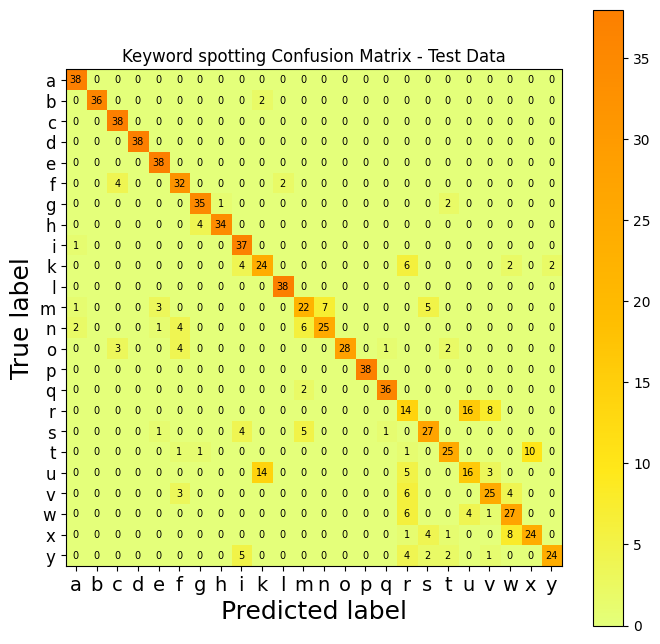

The accuracy is:  0.7883771929824561


In [ ]:
############ PROVA CON KERNEL GAUSSIANO OSSIA RBF ################

plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Keyword spotting Confusion Matrix - Test Data')

plt.ylabel('True label', fontsize=18)

plt.xlabel('Predicted label', fontsize=18)

tick_marks = np.arange(len(classNames))

plt.xticks(tick_marks, classNames, fontsize=14)

plt.yticks(tick_marks, classNames, fontsize=12)

plt.colorbar()#io

#s = [['Y','N','N','N','N'], ['N','Y','N','N','N'],['N','N','Y','N','N'],['N','N','N','Y','N'],['N','N','N','N','Y']]
accuracy = 0.0

for i in range(24):

    for j in range(24):

        #plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente
        if i == j:
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = accuracy/(38*24)

print('The accuracy is: ', accuracy)

In [ ]:
#### con linearSVC ####

from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

grid = {#'penalty': ['l1', 'l2'],
        #'loss': ['hinge', 'squared_hinge'],
        'C': np.logspace(-4,3,5)} # start point (10^), end point (10^), number of points, scala logaritimica

MS = GridSearchCV(estimator = LinearSVC(), #
                  param_grid = grid,
                  scoring = 'accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 1)

H = MS.fit(X_train,Y_train)


print('Logspace points C: ', H.best_params_['C'])

M = LinearSVC(#penalty = H.best_params_['penalty'],
        #loss = H.best_params_['loss'],
        C = H.best_params_['C'])


M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



<Figure size 640x480 with 0 Axes>

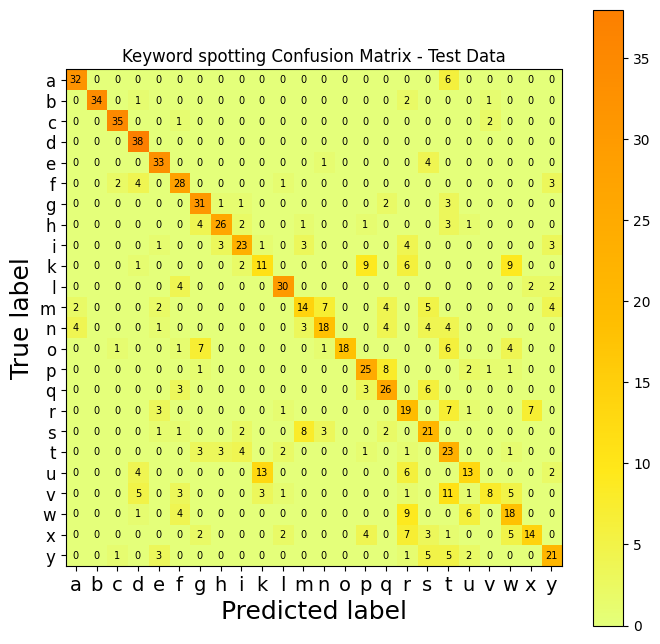

0.6129385964912281


In [ ]:
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Keyword spotting Confusion Matrix - Test Data')

plt.ylabel('True label', fontsize=18)

plt.xlabel('Predicted label', fontsize=18)

tick_marks = np.arange(len(classNames))

plt.xticks(tick_marks, classNames, fontsize=14)

plt.yticks(tick_marks, classNames, fontsize=12)

plt.colorbar()#io

#s = [['Y','N','N','N','N'], ['N','Y','N','N','N'],['N','N','Y','N','N'],['N','N','N','Y','N'],['N','N','N','N','Y']]
accuracy = 0.0

for i in range(24):

    for j in range(24):

        #plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente
        if i == j:
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = accuracy/(38*24)

print('The accuracy is: ', accuracy)